In [0]:
import torch
import torch.nn as nn #
import torch.nn.functional as F #
import torchvision # 이미지 관련 처리, Pretrained Model 관련된 Package 입니다. 
import torchvision.datasets as vision_dsets
import torchvision.transforms as transforms # 이미지 처리 (Vison) 관련된 transformation이 정의 되어 있습니다.
import torch.optim as optim # pytorch 에서 정의한 수 많은 optimization function 들이 들어 있습니다.
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt # 시각화를 위한 패키지입니다.

### Hyper-parameter 세팅 및 기타 변수 지정

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # pytorch0.4.0 이상 버젼에서 gpu 설정하는 방식, tensor.to(device) 이런식으로 사용
lr = 0.001
batch_size = 128
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

### 데이터 로딩

In [3]:
# Data
print('==> Preparing data..')
# 데이터 전처리를 위한 코드
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # 4만큼의 padding을 부여한 후, 32x32로 random cropping
    transforms.RandomHorizontalFlip(), # 0.5의 확률로 이미지 좌우 반전하여 넣어줌
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 랜덤 cropping을 하고, 이미지 좌우반전을 해주는 이유 : Data Augmentation!

# 데이터 전처리를 위한 코드
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # cifar10(0~1)의 r,g,b 채널 별 평균 및 분산으로 normalization => N(0,1)의 정규분포를 따르도록 만들어준 후 input으로 넣어줍니다.
])

# 데이터 로딩
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified


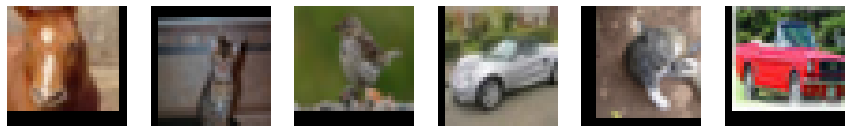

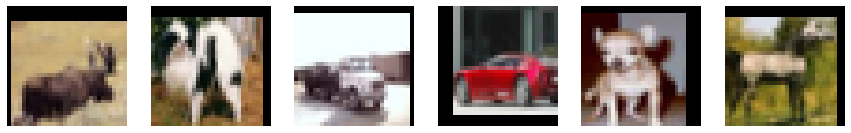

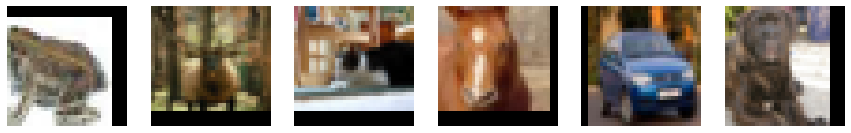

In [4]:
def showImages(image, row): # normalize 주석치고 show
  
  for _ in range(row):  
  
    idx = np.random.choice(batch_size, 6)     # 0 ~ 127 의 정수 중 6 개를 임의로 선택
    images =image.numpy()[idx].transpose(0,2,3,1)         # 선택된 index 에 해당하는 이미지를 가져옴
    plt.figure(figsize = (15, 90))     # 세로 길이 15, 가로 길이 15 * 6 의 화면 생성
    
    for i in range(161, 167):    
    
        plt.subplot(i)
        plt.imshow(images[i - 161])
        plt.xticks([])
        plt.yticks([])    
    
    plt.show()  

for i, (image, labels) in enumerate(trainloader): 
  
    showImages(image.squeeze(), 3)
    break

In [5]:
print('[info] # of train batch : ' ,len(trainloader))
print('[info] # of test batch : ', len(testloader))

[info] # of train batch :  391
[info] # of test batch :  100


### MNIST에서 사용했던 MLP를 적용해보자!

In [0]:
def train_network(net,optimizer,trainloader):
    for epoch in range(10):  # loop over the dataset multiple times

        running_loss = 0.0 # running loss를 저장하기 위한 변수입니다. 
        for i, data in enumerate(trainloader): # 한 Epoch 만큼 돕니다. 매 iteration 마다 정해진 Batch size 만큼 데이터를 뱉습니다. 
            # get the inputs
            inputs, labels = data # DataLoader iterator의 반환 값은 input_data 와 labels의 튜플 형식입니다. 
            inputs = inputs.to(device) # Pytorch에서 nn.Module 에 넣어 Backprop을 계산 하기 위해서는 gpu 연동을 이와 같이 해줘야 합니다.
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()    #  현재 기존의 backprop을 계산하기 위해서 저장했던 activation buffer 를 비웁니다.
            # forward + backward + optimize
            outputs = net(inputs) # input 을 넣은 위 network 로 부터 output 을 얻어냅니다. 
            loss = criterion(outputs, labels) # loss fucntion에 주어진 target과 output 의 score를 계산하여 반환합니다. 
            loss.backward() # * Scalar Loss value를 Backward() 해주게 되면 주어진 loss값을 바탕으로 backpropagation이 진행됩니다. 
            optimizer.step() # 계산된 Backprop 을 바탕으로 optimizer가 gradient descenting 을 수행합니다. 

            # print statistics
            running_loss += loss.data[0]
            if (i+1) % 100 == 0:    # print every 500 mini-batches
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training')

In [0]:
def test(model,test_loader):
    model.eval() # Eval Mode 왜 해야 할까요?  --> nn.Dropout BatchNorm 등의 Regularization 들이 test 모드로 들어가게 되기 때문입니다. 
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)  # 기존의 train function의 data 처리부분과 같습니다. 
        output = model(data) 
        pred = output.max(1, keepdim=True)[1] # get the index of the max 
        correct += pred.eq(target.view_as(pred)).sum().data[0] # 정답 데이터의 갯수를 반환합니다. 

    test_loss /= len(test_loader.dataset)
    print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.format(
      correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [0]:
class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        
        layer_list = [] # 이 리스트에 모든 Layer 를 순차적으로 append 해보겠습니다. 
        layer_list.append(nn.Linear(3*32*32,256)) #Layer 1 인풋 사이즈가 32*32, 거기에 RGB 3채널로 변경되었기 때문에 바꿔줍니다!!
        layer_list.append(nn.BatchNorm1d(256))#BatchNorm1
        layer_list.append(nn.ReLU())
        layer_list.append(nn.Linear(256, 64)) # Layer 2
        layer_list.append(nn.BatchNorm1d(64)) #BatchNorm1
        layer_list.append(nn.ReLU())
        layer_list.append(nn.Linear(64, 10)) # Layer 3
        self.net  = nn.Sequential(*layer_list) # nn.Sequential 에 layer list를 넘겨 줍니다.
        
    def forward(self, x):
        x = x.view(-1,32*32*3)
        x = self.net(x) # 넣은 순서대로 적용이 됩니다. 
        return x

In [0]:
mnist_net = MNIST_Net().to(device) # 생성한 뉴럴넷 Instance를 생성하고 빠른 학습을 위해 cuda 에 올립니다. 
criterion = nn.CrossEntropyLoss() # Loss Function을 정의 합니다. 여기서는 cross entrophy loss 를 사용합니다. 
optimizer = optim.Adam(mnist_net.parameters(), lr=lr) # optimizer는 이와 같이 training 할 Parameter와 learning rate를 인자로 줍니다. 

In [10]:
train_network(mnist_net,optimizer,trainloader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,   100] loss: 2.019
[1,   200] loss: 1.838
[1,   300] loss: 1.764
[2,   100] loss: 1.678
[2,   200] loss: 1.624
[2,   300] loss: 1.606
[3,   100] loss: 1.572
[3,   200] loss: 1.553
[3,   300] loss: 1.548
[4,   100] loss: 1.517
[4,   200] loss: 1.501
[4,   300] loss: 1.518
[5,   100] loss: 1.483
[5,   200] loss: 1.464
[5,   300] loss: 1.475
[6,   100] loss: 1.446
[6,   200] loss: 1.469
[6,   300] loss: 1.456
[7,   100] loss: 1.432
[7,   200] loss: 1.431
[7,   300] loss: 1.431
[8,   100] loss: 1.419
[8,   200] loss: 1.411
[8,   300] loss: 1.416
[9,   100] loss: 1.397
[9,   200] loss: 1.398
[9,   300] loss: 1.400
[10,   100] loss: 1.376
[10,   200] loss: 1.377
[10,   300] loss: 1.408
Finished Training


In [11]:
test(mnist_net,testloader) #일반적인 NN 성능좋지않다

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.



Test set:  Accuracy: 5169/10000 (51%)



### 심플한 CNN 모델을 만들어 봅시다.

<구성>

Layer 1 - input: 3 x 32 x 32, output: 64 x 32 x 32- ReLU + BatchNorm

Layer 2 - input: 64 x 32 x 32, output: 128 x 16 x 16- ReLU + BatchNorm (Down Conv라고 부릅니다.)

Layer 3 - Global Average Pooling (128 x 16 x 16 => 128 x 1 x 1)

Layer 4 - input: 128 x 1 x 1, output 10 x 1 x 1 - ReLU + BatchNorm

![대체 텍스트](https://cdn-images-1.medium.com/max/1600/1*D47ER7IArwPv69k3O_1nqQ.png)

In [0]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        layers = []

        layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)] # 첫 conv는 보통 receptive field를 최대한 넓혀준 후 feature를 뽑아줍니다.
        layers += [nn.BatchNorm2d(64)] # 앞선 MLP 시간과 달리 spatial resolution이 살아있기 때문에, batchnorm 2d를 사용해 줍니다.
        layers += [nn.ReLU()] # B X 64 X 32 X 32

        layers += [nn.Conv2d(64, 128, 4, 2, 1)] # down conv operation, spatial resolution을 줄이기(32->16) 위해 채널을 늘린다(64->128), 커널사이즈=4, stride=2이기에 중복되는 check패턴을 조금 줄이는 역할
        layers += [nn.BatchNorm2d(128)]
        layers += [nn.ReLU()] # B X 128 X 16 X 16

        layers += [nn.AdaptiveAvgPool2d(1)]

        layers += [nn.Conv2d(128, 10, 1, 1, 0)] # B X 128 X 1 X 1

        self.main = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.main(x).squeeze(3).squeeze(2) # 3,2 dimension 없애준다

In [0]:
def train_network(net,optimizer,trainloader):
    for epoch in range(10):  # loop over the dataset multiple times

        running_loss = 0.0 # running loss를 저장하기 위한 변수입니다. 
        for i, data in enumerate(trainloader): # 한 Epoch 만큼 돕니다. 매 iteration 마다 정해진 Batch size 만큼 데이터를 뱉습니다. 
            # get the inputs
            inputs, labels = data # DataLoader iterator의 반환 값은 input_data 와 labels의 튜플 형식입니다. 
            inputs = inputs.to(device) # Pytorch에서 nn.Module 에 넣어 Backprop을 계산 하기 위해서는 gpu 연동을 이와 같이 해줘야 합니다.
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()    #  현재 기존의 backprop을 계산하기 위해서 저장했던 activation buffer 를 비웁니다.

            # forward + backward + optimize
            outputs = net(inputs) # input 을 넣은 위 network 로 부터 output 을 얻어냅니다.
            loss = criterion(outputs, labels) # loss fucntion에 주어진 target과 output 의 score를 계산하여 반환합니다. 
            loss.backward() # * Scalar Loss value를 Backward() 해주게 되면 주어진 loss값을 바탕으로 backpropagation이 진행됩니다. 
            optimizer.step() # 계산된 Backprop 을 바탕으로 optimizer가 gradient descenting 을 수행합니다. 

            # print statistics
            running_loss += loss.data[0]
            if (i+1) % 100 == 0:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 100))
              running_loss = 0.0

    print('Finished Training')

In [0]:
def test(model,test_loader):
    model.eval() # Eval Mode 왜 해야 할까요?  --> nn.Dropout BatchNorm 등의 Regularization 들이 test 모드로 들어가게 되기 때문입니다. 
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)  # 기존의 train function의 data 처리부분과 같습니다. 
        output = model(data) 
        pred = output.max(1, keepdim=True)[1] # get the index of the max 
        correct += pred.eq(target.view_as(pred)).sum().data[0] # 정답 데이터의 갯수를 반환합니다. 

    test_loss /= len(test_loader.dataset)
    print('\nTest set:  Accuracy: {}/{} ({:.0f}%)\n'.format(
      correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [0]:
cifar_net = SimpleCNN().to(device) 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(cifar_net.parameters(), lr=lr)  

In [16]:
train_network(cifar_net,optimizer,trainloader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,   100] loss: 1.990
[1,   200] loss: 1.816
[1,   300] loss: 1.713
[2,   100] loss: 1.603
[2,   200] loss: 1.568
[2,   300] loss: 1.537
[3,   100] loss: 1.489
[3,   200] loss: 1.457
[3,   300] loss: 1.440
[4,   100] loss: 1.400
[4,   200] loss: 1.386
[4,   300] loss: 1.361
[5,   100] loss: 1.342
[5,   200] loss: 1.317
[5,   300] loss: 1.315
[6,   100] loss: 1.306
[6,   200] loss: 1.298
[6,   300] loss: 1.266
[7,   100] loss: 1.272
[7,   200] loss: 1.274
[7,   300] loss: 1.244
[8,   100] loss: 1.254
[8,   200] loss: 1.232
[8,   300] loss: 1.218
[9,   100] loss: 1.202
[9,   200] loss: 1.211
[9,   300] loss: 1.205
[10,   100] loss: 1.204
[10,   200] loss: 1.194
[10,   300] loss: 1.192
Finished Training


In [17]:
test(cifar_net,testloader) #성능좋지않다

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.



Test set:  Accuracy: 4727/10000 (47%)



### 직접 만들어 봅시다.

<구성>
Layer 1 - input: 3 x 32 x 32, output: 64 x 32 x 32- ReLU + BatchNorm    >>  k=7, s=1, p=3

Layer 2 - input: 64 x 32 x 32, output: 128 x 16 x 16- ReLU + BatchNorm    >>  k=4, s=2, p=1

Layer 3 - input: 128 x 16 x 16, output: 256 x 8 x 8- ReLU + BatchNorm    >>  k=?, s=?, p=?

Layer 4 - input: 256 x 8 x 8, output: 512 x 4 x 4 - ReLU + BatchNorm    >>  k=?, s=?, p=?

Layer 5 - Global Average Pooling (512 x 4 x 4 => 512 x 1 x 1)

Layer 6 - input: 512 x 1 x 1, output 10 x 1 x 1 - ReLU + BatchNorm    >>  k=?, s=?, p=?


In [0]:
class DiyCNN(nn.Module):
    def __init__(self):
        super(DiyCNN, self).__init__()
        layers = []

        layers += [nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)]
        layers += [nn.BatchNorm2d(64)] 
        layers += [nn.ReLU()]

        layers += [nn.Conv2d(64, 128, 4, 2, 1)]
        layers += [nn.BatchNorm2d(128)]
        layers += [nn.ReLU()]

        layers += [nn.Conv2d(128, 256, 4, 2, 1)]
        layers += [nn.BatchNorm2d(256)]
        layers += [nn.ReLU()]

        layers += [nn.Conv2d(256, 512, 4, 2, 1)]
        layers += [nn.BatchNorm2d(512)]
        layers += [nn.ReLU()]

        layers += [nn.AdaptiveAvgPool2d(1)]

        layers += [nn.Conv2d(512, 10, 1, 1, 0)]

        self.main = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.main(x).squeeze(3).squeeze(2)

In [0]:
cifar_net = DiyCNN().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(cifar_net.parameters(), lr=lr) 

In [20]:
train_network(cifar_net,optimizer,trainloader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,   100] loss: 1.740
[1,   200] loss: 1.505
[1,   300] loss: 1.378
[2,   100] loss: 1.219
[2,   200] loss: 1.164
[2,   300] loss: 1.113
[3,   100] loss: 1.036
[3,   200] loss: 1.010
[3,   300] loss: 0.965
[4,   100] loss: 0.919
[4,   200] loss: 0.908
[4,   300] loss: 0.861
[5,   100] loss: 0.828
[5,   200] loss: 0.799
[5,   300] loss: 0.809
[6,   100] loss: 0.750
[6,   200] loss: 0.750
[6,   300] loss: 0.728
[7,   100] loss: 0.679
[7,   200] loss: 0.689
[7,   300] loss: 0.707
[8,   100] loss: 0.650
[8,   200] loss: 0.659
[8,   300] loss: 0.637
[9,   100] loss: 0.604
[9,   200] loss: 0.612
[9,   300] loss: 0.608
[10,   100] loss: 0.572
[10,   200] loss: 0.582
[10,   300] loss: 0.570
Finished Training


In [21]:
test(cifar_net,testloader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.



Test set:  Accuracy: 7585/10000 (75%)



### Layer가 많아지면 많아질수록 반복되는 라인이 반복 -> ConvBlock을 사용하여 코딩해보기!

위와 동일한 네트워크를 conv block을 사용하여 코딩해봅시다!

<구성>
Layer 1 - input: 3 x 32 x 32, output: 64 x 32 x 32- ReLU + BatchNorm    >>  k=7, s=1, p=3

Layer 2 - input: 64 x 32 x 32, output: 128 x 16 x 16- ReLU + BatchNorm    >>  k=4, s=2, p=1

Layer 3 - input: 128 x 16 x 16, output: 256 x 8 x 8- ReLU + BatchNorm    >>  k=?, s=?, p=?

Layer 4 - input: 256 x 8 x 8, output: 512 x 4 x 4 - ReLU + BatchNorm    >>  k=?, s=?, p=?

Layer 5 - Global Average Pooling (512 x 4 x 4 => 512 x 1 x 1)

Layer 6 - input: 512 x 1 x 1, output 10 x 1 x 1 - ReLU + BatchNorm    >>  k=?, s=?, p=?


In [0]:
class ConvBlock(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size, stride, padding, norm='none', activation='none'):
        super(ConvBlock, self).__init__()

        # Init Normalization
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(output_dim)
        elif norm == 'none':
            self.norm = None

        # Init Activation
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'none':
            self.activation = None

        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride, padding)
    
    def forward(self, x):
        x = self.conv(x)
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x

In [0]:
class DiyCNN_v2(nn.Module):
    def __init__(self):
        super(DiyCNN_v2, self).__init__()
        layers = []
        layers += [ConvBlock(input_dim=3, output_dim=64, kernel_size=7, stride=1, padding=3, norm='bn', activation='relu')]
        layers += [ConvBlock(input_dim=64, output_dim=128, kernel_size=4, stride=2, padding=1, norm='bn', activation='relu')]
        layers += [ConvBlock(input_dim=128, output_dim=256, kernel_size=4, stride=2, padding=1, norm='bn', activation='relu')]
        layers += [ConvBlock(input_dim=256, output_dim=512, kernel_size=4, stride=2, padding=1, norm='bn', activation='relu')]
        layers += [nn.AdaptiveAvgPool2d(1)]
        layers += [nn.Conv2d(512, 10, 1, 1, 0)]
        self.main = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.main(x).squeeze(3).squeeze(2)

In [0]:
cifar_net2 = DiyCNN_v2().to(device) 
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(cifar_net2.parameters(), lr=lr) 

In [0]:
train_network(cifar_net2,optimizer,trainloader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


[1,   100] loss: 1.747
[1,   200] loss: 1.526
[1,   300] loss: 1.391
[2,   100] loss: 1.230
[2,   200] loss: 1.162
[2,   300] loss: 1.132
[3,   100] loss: 1.045
[3,   200] loss: 1.001
[3,   300] loss: 0.983
[4,   100] loss: 0.926
[4,   200] loss: 0.910
[4,   300] loss: 0.869
[5,   100] loss: 0.814
[5,   200] loss: 0.813
[5,   300] loss: 0.795
[6,   100] loss: 0.754
[6,   200] loss: 0.742
[6,   300] loss: 0.729
[7,   100] loss: 0.706
[7,   200] loss: 0.694
[7,   300] loss: 0.670
[8,   100] loss: 0.651
[8,   200] loss: 0.636
[8,   300] loss: 0.650
[9,   100] loss: 0.604
[9,   200] loss: 0.618
[9,   300] loss: 0.594
[10,   100] loss: 0.577
[10,   200] loss: 0.568
[10,   300] loss: 0.559
Finished Training


In [0]:
test(cifar_net2,testloader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.



Test set:  Accuracy: 7795/10000 (77%)



### vgg16



---

![대체 텍스트](https://jsideas.net/assets/cand_faces/vgg16.png)

In [0]:
'''VGG11/13/16/19 in Pytorch.'''

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
      

In [0]:
print('==> Building model..')
net = VGG('VGG16') # VGG 네트워크 변수에 저장

net = net.to(device)
#if device == 'cuda':
#     net = torch.nn.DataParallel(net) # gpu 병렬처리 할 때 사용

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4) # momentum: 마치 관성처럼, 이전에 업데이트한 량을 다음 스텝의 업데이트에도 반영하겠다는 아이디어, # weight_decay: L2 regularization 계수값 (오버피팅 방지)
# optimizer = optim.Adam(mnist_net.parameters(), lr=lr) # optimizer는 이처럼 모두 테스트 해본 뒤 잘 나오는 것으로 선택하는 경우가 대부분입니다.

==> Building model..


In [0]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train() # 훈련모드 설정
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device) # tensor들을 gpu에 올려주는 코드입니다.
        optimizer.zero_grad() # 기존의 backprop을 계산하기 위해서 저장했던 activation buffer 를 비웁니다.
        outputs = net(inputs) # 네트워크로 인풋 데이터 포워딩합니다.
        loss = criterion(outputs, targets) # 손실값(loss) 계산합니다.
        loss.backward() # Backpropagation
        optimizer.step() # 각각의 tensor들에 역전파 된 양만큼 파라미터를 업데이트합니다.

        train_loss += loss.item() # 출력을 위해 loss를 저장합니다.
        _, predicted = outputs.max(1) # top 1 예측값 (비행기? 차? 새? ...)을 저장해줍니다. 
        total += targets.size(0) # 평균을 내기 위해 (총 합을 n으로 나눠주기 위해) n(배치 사이즈)을 구해줍니다.
        correct += predicted.eq(targets).sum().item() # 정답과 예측값을 비교해 맞춘 것은 1, 틀린 것은 0으로 하여 전부 다 더해줍니다. (맞춘 개수) <= 이것을 위의 n으로 나눠주면 '평균 정확도'가 됩니다.

        # print statistics
        train_loss += loss.data[0]
        if (batch_idx+1) % 20 == 0:    # print every 500 mini-batches
            print('train : [%d, %5d] loss: %.3f' %
                  (epoch + 1, batch_idx + 1, train_loss / 20))
            train_loss = 0.0

In [0]:
def test(epoch):
    global best_acc
    net.eval() # 테스트모드 설정
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device) # tensor들을 gpu에 올려주는 코드입니다.
            outputs = net(inputs) # 네트워크로 인풋 데이터 포워딩합니다.
            loss = criterion(outputs, targets) # 손실값(loss) 계산합니다.

            test_loss += loss.item() # 출력을 위해 loss를 저장합니다.
            _, predicted = outputs.max(1) # top 1 예측값 (비행기? 차? 새? ...)을 저장해줍니다. 
            total += targets.size(0) # 평균을 내기 위해 (총 합을 n으로 나눠주기 위해) n(배치 사이즈)을 구해줍니다.
            correct += predicted.eq(targets).sum().item() # 정답과 예측값을 비교해 맞춘 것은 1, 틀린 것은 0으로 하여 전부 다 더해줍니다. (맞춘 개수) <= 이것을 위의 n으로 나눠주면 '평균 정확도'가 됩니다.

            # print statistics
            test_loss += loss.data[0]
            if (batch_idx+1) % 20 == 0:    # print every 500 mini-batches
                print('test : [%d, %5d] loss: %.3f' %
                      (epoch + 1, batch_idx + 1, test_loss / 20))
                test_loss = 0.0

In [0]:
for epoch in range(start_epoch, start_epoch+10): # 0부터 9까지, 총 10번의 epoch을 돌리겠다는 의미입니다.
    train(epoch) # train 함수 호출
    test(epoch) # test 함수 호출
    
print('Finished Training')

# 200 epoch 결과 => 92.64%